In [1]:
# Gerekli kütüphaneleri yükleyin
!pip install transformers torch torchvision
from transformers import AutoFeatureExtractor, BeitForImageClassification
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import time

# Drive'a bağlanın
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Veri seti yolunu belirleyin
data_dir = "/content/drive/My Drive/YapayZekaRessam/"

# Dönüşümleri tanımlayın
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Veri setlerini yükleyin
train_dataset = datasets.ImageFolder(root=data_dir + "train", transform=transform)
val_dataset = datasets.ImageFolder(root=data_dir + "val", transform=transform)

# Veri yükleyicilerini oluşturun
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}


In [4]:
# Beit modelini ve özellik çıkarıcıyı yükleyin
feature_extractor = AutoFeatureExtractor.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')
model = BeitForImageClassification.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k',
                                                      num_labels=10,
                                                      ignore_mismatched_sizes=True) # Add this line

# Cihazı ayarlayın
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Kaybı ve optimize ediciyi tanımlayın
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

/usr/local/lib/python3.10/dist-packages/transformers/models/beit/feature_extraction_beit.py:28: FutureWarning: The class BeitFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use BeitImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `BeitFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)
Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k-ft22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stre

In [6]:
num_epochs = 2
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
start_time = time.time()

def train_epoch(model, dataloaders, dataset_sizes, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for i, (inputs, labels) in enumerate(dataloaders['train']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs).logits
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # Her 10 batch'te bir bilgi verelim
        if (i + 1) % 10 == 0:
            batch_accuracy = torch.sum(preds == labels.data).item() / labels.size(0)
            print(f'Batch {i+1}/{len(dataloaders["train"])}: Train Loss: {loss.item():.4f}, Batch Accuracy: {batch_accuracy*100:.2f}%')

    epoch_loss = running_loss / dataset_sizes['train']
    epoch_acc = running_corrects.double() / dataset_sizes['train'] * 100

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f'Epoch Train Loss: {epoch_loss:.4f}, Epoch Train Accuracy: {epoch_acc:.2f}%')
    return epoch_loss, epoch_acc

def validate_epoch(model, dataloaders, dataset_sizes, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for i, (inputs, labels) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs).logits
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # Her 10 batch'te bir bilgi verelim
        if (i + 1) % 10 == 0:
            batch_accuracy = torch.sum(preds == labels.data).item() / labels.size(0)
            print(f'Batch {i+1}/{len(dataloaders["val"])}: Val Loss: {loss.item():.4f}, Batch Accuracy: {batch_accuracy*100:.2f}%')

    epoch_loss = running_loss / dataset_sizes['val']
    epoch_acc = running_corrects.double() / dataset_sizes['val'] * 100

    val_losses.append(epoch_loss)
    val_accuracies.append(epoch_acc)

    print(f'Epoch Val Loss: {epoch_loss:.4f}, Epoch Val Accuracy: {epoch_acc:.2f}%')
    return epoch_loss, epoch_acc

for epoch in range(1, num_epochs + 1):
    print(f'Epoch {epoch}/{num_epochs}')
    print('-' * 10)

    train_loss, train_acc = train_epoch(model, dataloaders, dataset_sizes, optimizer, criterion, device)
    val_loss, val_acc = validate_epoch(model, dataloaders, dataset_sizes, criterion, device)

training_time = time.time() - start_time
print(f'Total Training Time: {training_time:.2f} seconds')

print('Eğitim tamamlandı')


Epoch 1/2
----------
Batch 10/425: Train Loss: 0.0508, Batch Accuracy: 98.44%
Batch 20/425: Train Loss: 0.0632, Batch Accuracy: 99.22%
Batch 30/425: Train Loss: 0.0136, Batch Accuracy: 100.00%
Batch 40/425: Train Loss: 0.0106, Batch Accuracy: 100.00%
Batch 50/425: Train Loss: 0.0379, Batch Accuracy: 99.22%
Batch 60/425: Train Loss: 0.0251, Batch Accuracy: 99.22%
Batch 70/425: Train Loss: 0.0017, Batch Accuracy: 100.00%
Batch 80/425: Train Loss: 0.0028, Batch Accuracy: 100.00%
Batch 90/425: Train Loss: 0.0033, Batch Accuracy: 100.00%
Batch 100/425: Train Loss: 0.0064, Batch Accuracy: 100.00%
Batch 110/425: Train Loss: 0.0093, Batch Accuracy: 99.22%
Batch 120/425: Train Loss: 0.0013, Batch Accuracy: 100.00%
Batch 130/425: Train Loss: 0.0229, Batch Accuracy: 98.44%
Batch 140/425: Train Loss: 0.0015, Batch Accuracy: 100.00%
Batch 150/425: Train Loss: 0.0173, Batch Accuracy: 98.44%
Batch 160/425: Train Loss: 0.0058, Batch Accuracy: 100.00%
Batch 170/425: Train Loss: 0.0172, Batch Accuracy: 

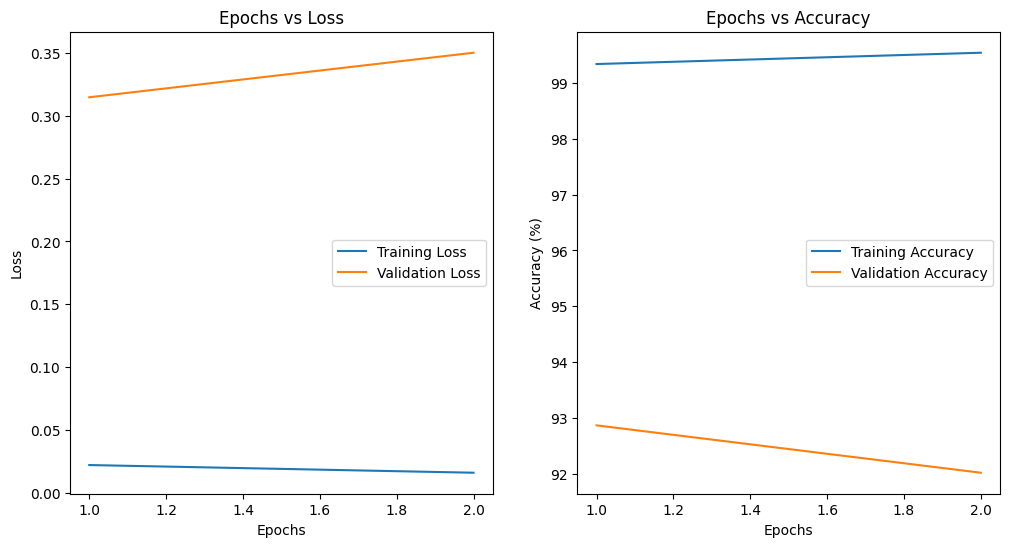

In [8]:
# Eğitim ve doğrulama kayıp ve doğruluk grafiklerini çizelim
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs vs Loss')
plt.legend()

plt.subplot(1, 2, 2)
# Convert train_accuracies and val_accuracies to NumPy arrays on CPU
plt.plot(epochs, [acc.cpu().numpy() for acc in train_accuracies], label='Training Accuracy')  # Changed line
plt.plot(epochs, [acc.cpu().numpy() for acc in val_accuracies], label='Validation Accuracy')  # Changed line
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Epochs vs Accuracy')
plt.legend()

plt.show()


In [9]:
# Modeli kaydetmek için klasör oluşturun (varsa atlayabilirsiniz)
import os
save_path = "/content/drive/My Drive/BeitModel/model"
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Modeli ve özellik çıkarıcıyı kaydedin
model.save_pretrained(save_path)
feature_extractor.save_pretrained(save_path)

# Eğitim ve doğrulama kayıp ve doğruluk değerlerini kaydedin
training_data = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'training_time': training_time
}

import pickle
with open(os.path.join(save_path, 'training_data.pkl'), 'wb') as f:
    pickle.dump(training_data, f)

print("Model, özellik çıkarıcı ve eğitim verileri başarıyla kaydedildi!")


Model, özellik çıkarıcı ve eğitim verileri başarıyla kaydedildi!


test

In [10]:
# Gerekli kütüphaneleri yükleyin
!pip install transformers torch torchvision scikit-learn seaborn
from transformers import AutoFeatureExtractor, BeitForImageClassification
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import os
import time

# Drive'a bağlanın
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# Kaydedilen modeli ve özellik çıkarıcıyı yükleyin
load_path = "/content/drive/My Drive/BeitModel/model"
model = BeitForImageClassification.from_pretrained(load_path)
feature_extractor = AutoFeatureExtractor.from_pretrained(load_path)

# Cihazı ayarlayın
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Eğitim ve doğrulama kayıp ve doğruluk değerlerini yükleyin
import pickle
with open(os.path.join(load_path, 'training_data.pkl'), 'rb') as f:
    training_data = pickle.load(f)

train_losses = training_data['train_losses']
val_losses = training_data['val_losses']
train_accuracies = training_data['train_accuracies']
val_accuracies = training_data['val_accuracies']
training_time = training_data['training_time']

print("Model ve eğitim verileri başarıyla yüklendi!")


/usr/local/lib/python3.10/dist-packages/transformers/models/beit/feature_extraction_beit.py:28: FutureWarning: The class BeitFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use BeitImageProcessor instead.
  warnings.warn(


Model ve eğitim verileri başarıyla yüklendi!


In [12]:
# Test veri seti yolunu belirleyin (test verilerinizin bulunduğu klasör)
test_data_dir = "/content/drive/My Drive/YapayZekaRessam/test"

# Dönüşümleri tanımlayın
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Test veri setini yükleyin
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)


In [13]:
gercek = []
tahmin = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).logits
        _, predicted = torch.max(outputs, 1)

        gercek.extend(labels.cpu().numpy())
        tahmin.extend(predicted.cpu().numpy())

confMatrix = confusion_matrix(gercek, tahmin)

def hesaplaSpecificity(confMatrix):
    specificitySinifBasina = []
    for i in range(len(confMatrix)):
        tn = confMatrix.sum() - (confMatrix[i, :].sum() + confMatrix[:, i].sum() - confMatrix[i, i])
        fp = confMatrix[:, i].sum() - confMatrix[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificitySinifBasina.append(specificity)
    return np.mean(specificitySinifBasina)

specificity = hesaplaSpecificity(confMatrix)

accuracy = accuracy_score(gercek, tahmin)
precision = precision_score(gercek, tahmin, average='weighted')
recall = recall_score(gercek, tahmin, average='weighted')
fScore = f1_score(gercek, tahmin, average='weighted')

olasilik = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs).logits
        olasiliklar = torch.softmax(outputs, dim=1)
        olasilik.extend(olasiliklar.cpu().numpy())

gercekOneHot = np.eye(len(np.unique(gercek)))[gercek]
auc = roc_auc_score(gercekOneHot, np.array(olasilik), average='weighted', multi_class='ovr')

print(f"Accuracy: %{accuracy * 100:.2f}")
print(f"Precision: %{precision * 100:.2f}")
print(f"Recall: %{recall * 100:.2f}")
print(f"Specificity: %{specificity * 100:.2f}")
print(f"F-Score: %{fScore * 100:.2f}")
print(f"AUC: %{auc * 100:.2f}")


Accuracy: %91.65
Precision: %92.01
Recall: %91.65
Specificity: %99.05
F-Score: %91.66
AUC: %99.41


In [14]:
def cikarimHesap(model, test_loader, device):
    model.eval()
    baslangicZamani = time.time()

    with torch.no_grad():
        for gorseller, _ in test_loader:
            gorseller = gorseller.to(device)
            cikti = model(gorseller)

    bitisZamani = time.time()
    cikarmaZamani = bitisZamani - baslangicZamani
    return cikarmaZamani

cikarmaZamani = cikarimHesap(model, test_loader, device)
print(f'Çıkarım Zamanı: {cikarmaZamani:.2f} saniye')


Çıkarım Zamanı: 2.93 saniye


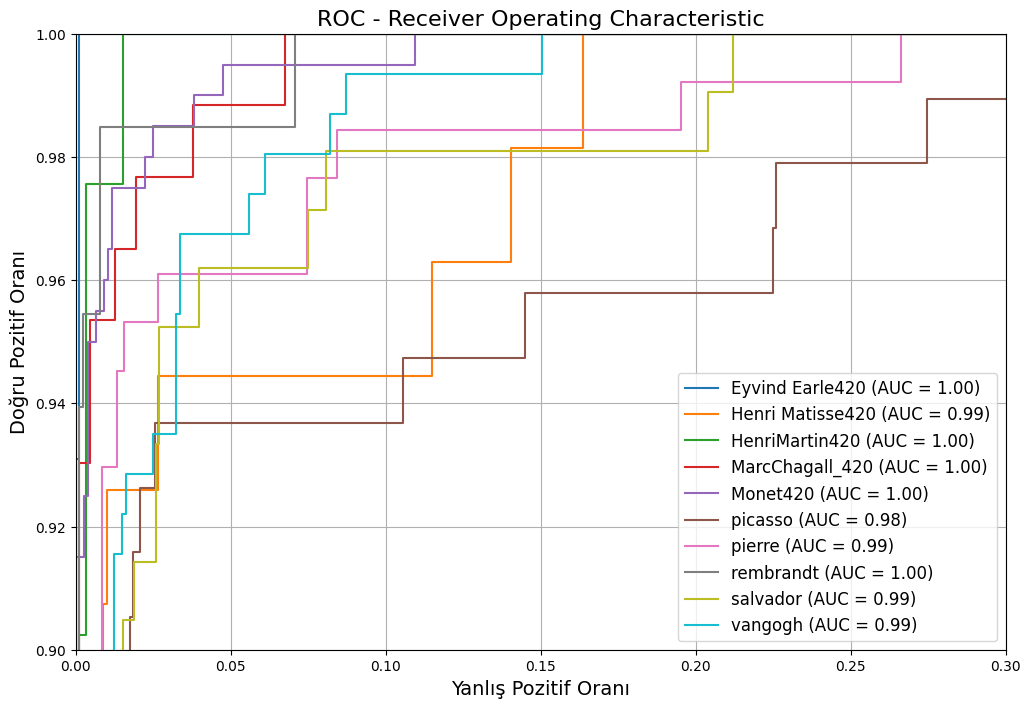

In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import sklearn.metrics  # Add this line to import the sklearn.metrics module

# ... (other imports)

# ... (other code)

def ROCEgrisi(gercek, olasilik, sinifAdlari):
    plt.figure(figsize=(12, 8))

    for i, sinifAdi in enumerate(sinifAdlari):
        fpr, tpr, _ = roc_curve(gercek[:, i], olasilik[:, i])
        # Use sklearn.metrics.auc instead of the variable 'auc'
        roc_auc = sklearn.metrics.auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'{sinifAdi} (AUC = {roc_auc:.2f})')

    plt.xlim([0.0, 0.3])
    plt.ylim([0.9, 1.0])
    plt.xlabel('Yanlış Pozitif Oranı', fontsize=14)
    plt.ylabel('Doğru Pozitif Oranı', fontsize=14)
    plt.title('ROC - Receiver Operating Characteristic', fontsize=16)
    plt.legend(loc='lower right', prop={'size': 12})
    plt.grid(True)
    plt.show()

gercek = []
olasilik = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).logits
        olasiliklar = torch.softmax(outputs, dim=1)

        gercek.extend(labels.cpu().numpy())
        olasilik.extend(olasiliklar.cpu().numpy())

gercekOneHot = np.eye(len(np.unique(gercek)))[gercek]
olasilik = np.array(olasilik)

sinifAdlari = test_dataset.classes

ROCEgrisi(gercekOneHot, olasilik, sinifAdlari)


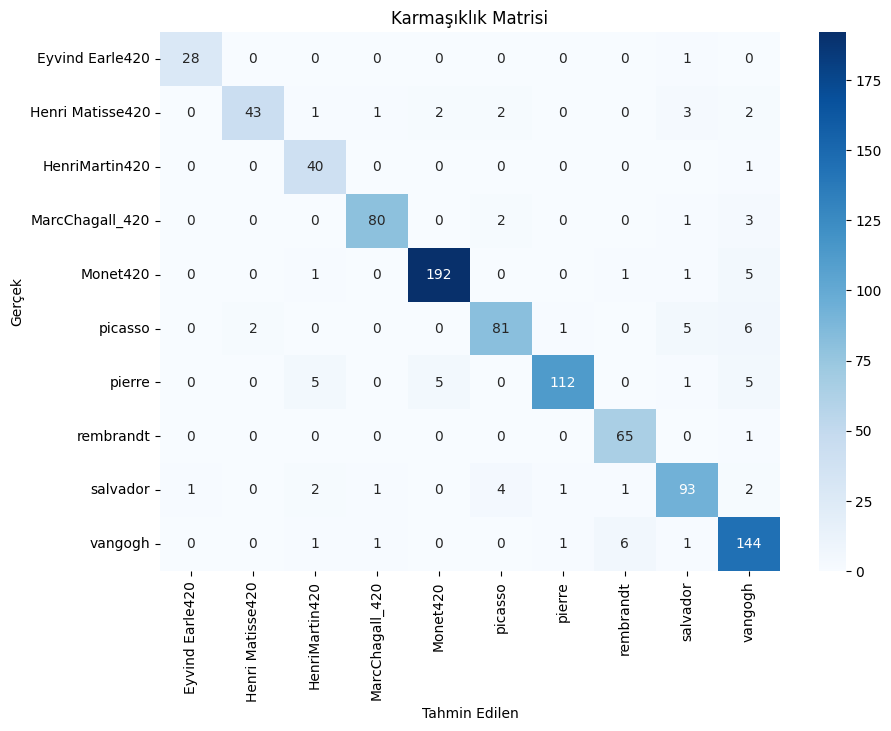

In [19]:
def karmasiklikMatris(gercek, tahmin, sinifAdlari):
    confMatrix = confusion_matrix(gercek, tahmin)

    plt.figure(figsize=(10, 7))
    sns.heatmap(confMatrix, annot=True, fmt='d', cmap='Blues', xticklabels=sinifAdlari, yticklabels=sinifAdlari)
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Gerçek')
    plt.title('Karmaşıklık Matrisi')
    plt.show()

gercek = []
tahmin = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).logits
        _, predicted = torch.max(outputs, 1)

        gercek.extend(labels.cpu().numpy())
        tahmin.extend(predicted.cpu().numpy())

sinifAdlari = test_dataset.classes

karmasiklikMatris(gercek, tahmin, sinifAdlari)
